# 1. Import Python Packages

To install the kernel used by NERSC-metatlas users, copy the following text to $HOME/.ipython/kernels/mass_spec_cori/kernel.json

```
{
 "argv": [
  "/global/common/software/m2650/python-cori/bin/python",
  "-m",
  "IPython.kernel",
  "-f",
  "{connection_file}"
 ],
 "env": {
    "PATH": "/global/common/software/m2650/python-cori/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin"
 },
 "display_name": "mass_spec_cori",
 "language": "python"
}
```

In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

%matplotlib inline
%env HDF5_USE_FILE_LOCKING=FALSE
import sys, os

#### add a path to your private code if not using production code ####
#print ('point path to metatlas repo')
sys.path.insert(0,"/global/homes/v/vrsingan/repos/metatlas/") #where your private code is
######################################################################

from metatlas.helpers import dill2plots as dp
from metatlas.helpers import metatlas_get_data_helper_fun as ma_data
from metatlas.helpers import chromatograms_mp_plots as cp
from metatlas.helpers import chromplotplus as cpp
import metatlas.metatlas_objects as metob
from metatlas.helpers import mzmine_helpers as mzm

import qgrid

from ipywidgets import interact, interactive, fixed, IntProgress
import ipywidgets as widgets
from IPython.display import display, clear_output

import time
import dill
import numpy as np
import multiprocessing as mp
import pandas as pd

import glob
import re

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

def printmd(string):
    display(Markdown(string))

env: HDF5_USE_FILE_LOCKING=FALSE
('NERSC=', True)


## 2. Select groups and get QC files

In [2]:
dp = reload(dp)
groups = dp.select_groups_for_analysis(name = '%20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560%',
                                       most_recent = True,
                                       remove_empty = True,
                                       include_list = ['QC'], exclude_list = [])  #['QC','Blank']

/global/common/software/m2650/python-cori/lib/python2.7/site-packages/pymysql/cursors.py:166: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


1
(0, u'20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_vrs1_QC', datetime.datetime(2019, 10, 18, 23, 6, 24))


In [3]:
for g in groups:
    for f in g.items:
         print f.name

20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_8_1S-Set1-B_2_-Salt-QC_82.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_59_12-Ctrl-Set2-B_4_-noD2O-QC_304.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_27_4S-Set1-B_3_-Salt-QC_119.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Pre_--QC_6.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_7_1S-Set1-B_1_-Salt-QC_45.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_69_12-ColdwD2O-Set2-B_2_-D2O-QC_230.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_73_24-Ctrl-Set2-B_2_-noD2O-QC_193.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_56_12-Ctrl-Set2-B_1_-noD2O-QC_156.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_202_ExCtrl-Set2-B_3_-ExCtrl-QC_267.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Post_--QC_345.mzML


## 3. Get template QC atlas from database

In [4]:
#Atlas File Name 
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Template' # RT space
CPD = 'QCv3' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity

QC_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL))

atlases = metob.retrieve('Atlas',name=QC_template_filename,
                         username='vrsingan')
names = []
for i,a in enumerate(atlases):
    print(i,a.name,pd.to_datetime(a.last_modified,unit='s'),len(a.compound_identifications))

(0, u'MSMLS_HILICz150mm_Annotation20190824_Template_QCv3_Unlabeled_Positive', Timestamp('2020-02-28 16:14:28'), 72)


In [5]:
# #Alternatively use this block to create QC atlas from spreadsheet
# import datetime
#dp = reload(dp)

# LCS = 'MSMLS' # Library Compound Set
# CTY = 'HILICz150mm' # Chromatography
# LR = 'Annotation20190824' # Library Run
# RTS = 'Template' # RT space
# CPD = 'QCv3' # Set of Compounds
# LAB = 'Unlabeled' # Isolabeling
# POL = 'Positive' # Polarity
# DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')
# QC_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

#myAtlas = dp.make_atlas_from_spreadsheet('/global/project/projectdirs/metatlas/projects/1_TemplateAtlases/TemplateAtlas_HILICz150mm_Annotation20190824_QCv3_Unlabeled_Positive.csv',
#                                       QC_template_filename,
#                                        filetype='csv',
#                                        sheetname='',
#                                        polarity = 'positive',
#                                        store=True,
#                                       mz_tolerance = 20)
#atlases = dp.get_metatlas_atlas(name=QC_template_filename,do_print = True,most_recent=True)

In [6]:
myAtlas = atlases[-1]
atlas_df = ma_data.make_atlas_df(myAtlas)
atlas_df['label'] = [cid.name for cid in myAtlas.compound_identifications]
print myAtlas.name
print myAtlas.username

((72, 15), 72)
MSMLS_HILICz150mm_Annotation20190824_Template_QCv3_Unlabeled_Positive
vrsingan


## 3b. Uncomment the block below to adjust RT window

In [7]:
# rt_allowance = 0.5
# atlas_df['rt_min'] = atlas_df['rt_peak'].apply(lambda rt: rt-rt_allowance)
# atlas_df['rt_max'] = atlas_df['rt_peak'].apply(lambda rt: rt+rt_allowance)

# 4. Create metatlas dataset from QC files and QC atlas

In [8]:
all_files = []
for my_group in groups:
    for my_file in my_group.items:
        all_files.append((my_file,my_group,atlas_df,myAtlas))
        
pool = mp.Pool(processes=min(4, len(all_files)))
t0 = time.time()
metatlas_dataset = pool.map(ma_data.get_data_for_atlas_df_and_file, all_files)
pool.close()
pool.terminate()
#If you're code crashes here, make sure to terminate any processes left open.
print time.time() - t0

6.11699080467


# 5. Create RT adjustment model

In [10]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_absolute_error as mae

ransac = RANSACRegressor(random_state=42)
qc_actual_df = dp.make_output_dataframe(input_dataset = metatlas_dataset, fieldname='rt_peak', use_labels=True) # Peak height filter??
maes, coefs, intercepts = [],[],[]
actual_rts, pred_rts = [],[]
for i in range(qc_actual_df.shape[1]):
    current_actual_df = qc_actual_df.loc[:,qc_actual_df.columns[i]]
    bad_qc_compounds = np.where(~np.isnan(current_actual_df))
    current_actual_df = current_actual_df.iloc[bad_qc_compounds]
    current_pred_df = atlas_df.iloc[bad_qc_compounds][['rt_peak']]
    actual_rts.append(current_actual_df.values.tolist())
    pred_rts.append(current_pred_df.values.tolist())
    
    rt_model = ransac.fit(current_pred_df, current_actual_df)
    
    coefs.append(rt_model.estimator_.coef_)
    intercepts.append(rt_model.estimator_.intercept_)
    maes.append(mae(rt_model.estimator_.coef_*current_pred_df+
                   rt_model.estimator_.intercept_, current_actual_df))

## 6. Plot MAE (mean absolute error) for all QC files  
Index and file name of the QC file with the least MAE is highlighted.<br />
Dark Red and Dark Blue lines represent Coeff and Intercept values for each of the QC files.<br /> 
Light Red and Light Blue lines show the median Coeff and Intercept value.

__QCFileIndex&emsp;QCFileName__

0&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_8_1S-Set1-B_2_-Salt-QC_82.h5

1&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_59_12-Ctrl-Set2-B_4_-noD2O-QC_304.h5

2&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_27_4S-Set1-B_3_-Salt-QC_119.h5

3&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Pre_--QC_6.h5

__4&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_7_1S-Set1-B_1_-Salt-QC_45.h5__

5&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_69_12-ColdwD2O-Set2-B_2_-D2O-QC_230.h5

6&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_73_24-Ctrl-Set2-B_2_-noD2O-QC_193.h5

7&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_56_12-Ctrl-Set2-B_1_-noD2O-QC_156.h5

8&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_202_ExCtrl-Set2-B_3_-ExCtrl-QC_267.h5

9&emsp;&emsp;20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Post_--QC_345.h5

Text(0.5,0,'QCs')

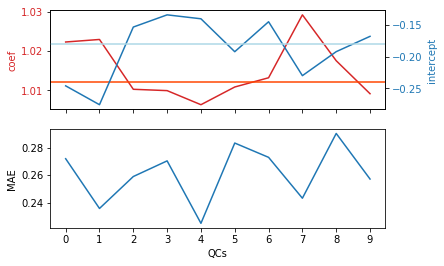

In [11]:
printmd("__QCFileIndex&emsp;QCFileName__")
for i in range(qc_actual_df.shape[1]):
    if maes[i] == min(maes):
        QCFileIndex = i
        printmd("__"+str(i)+"&emsp;&emsp;"+qc_actual_df.columns[i][1]+"__")
    else:
        printmd(str(i)+"&emsp;&emsp;"+qc_actual_df.columns[i][1])
        

fig, axes = plt.subplots(2, sharex=True)
color = 'tab:red'
axes[0].set_ylabel('coef', color=color)
axes[0].plot(coefs, color=color)
axes[0].tick_params(axis='y', labelcolor=color)
axes[0].axhline(y=np.median(coefs),color='orangered')

ax2 = axes[0].twinx()
color = 'tab:blue'
ax2.set_ylabel('intercept', color=color)  
ax2.plot(intercepts, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=np.median(intercepts),color='lightblue')

axes[1].plot(maes)
axes[1].set_xticks(np.arange(len(maes)))
# axes[1].set_xticklabels(qc_actual_df.columns, rotation=90)
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('QCs')


## 7. Plot actual vs predict RT values and fit a  median coeff+intercept line

Text(0,0.5,'actual RTs')

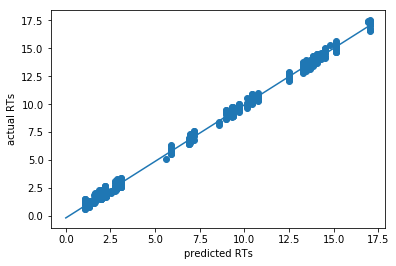

In [12]:
#User can change to use particular qc file
import itertools
x = list(itertools.chain(*pred_rts))
y = list(itertools.chain(*actual_rts))

coef = np.median(coefs)
intercept = np.median(intercepts)

plt.scatter(x,y)
plt.plot(np.linspace(0, max(x), 100), coef*np.linspace(0, max(x), 100)+intercept)
plt.xlabel('predicted RTs')
plt.ylabel('actual RTs')

## 8. Plot actual vs predict RT values and fit a coeff+intercept line for a specific QC file (optional)

Text(0,0.5,'actual RTs')

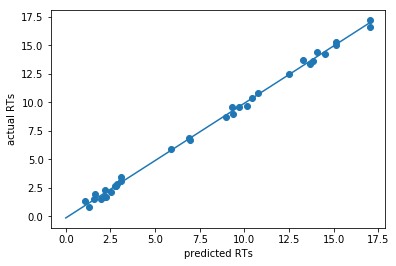

In [15]:
# #QCFileIndex = 1
# coef = coefs[QCFileIndex]
# intercept = intercepts[QCFileIndex]

# x = list(itertools.chain(*pred_rts[QCFileIndex]))
# y = actual_rts[QCFileIndex]
# #x=qc_pred_df.values
# #y=qc_actual_df.iloc[:,QCFileIndex].values

# plt.scatter(x, y)
# plt.plot(np.linspace(0, max(x),100), coef*np.linspace(0,max(x),100)+intercept)
# plt.xlabel('predicted RTs')
# plt.ylabel('actual RTs')

## 9. Save RT model (optional)

In [ ]:
# Save model
#with open('./rt_model', 'w') as f:
#    f.write('coef = {}\nintercept = {}\nqc_actual_rts = {}\nqc_predicted_rts = {}'.format(
#                                                                                    coef, 
#                                                                                    intercept, 
#                                                                                    ', '.join([g.name for g in groups]), 
#                                                                                    os.path.realpath(qc_predicted_path)))
#    f.write('\n'+repr(rt_model.set_params()))

## 10. Auto RT adjust original QC atlas

In [13]:
import datetime

#Atlas File Name
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Predicted' # RT space
CPD = 'QCv3' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity
FT = '' # Free Text
DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')


if FT != '':
    QC_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,FT,DT))
else:
    QC_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

QC_atlas_df = atlas_df
QC_atlas_df['rt_peak'] = QC_atlas_df['rt_peak'].apply(lambda rt: coef*rt+intercept)
QC_atlas_df['rt_min'] = QC_atlas_df['rt_peak'].apply(lambda rt: rt-.5)
QC_atlas_df['rt_max'] = QC_atlas_df['rt_peak'].apply(lambda rt: rt+.5)

QC_atlas_df.to_csv(os.path.join('./', QC_predicted_filename), index=False)

# Optionally save in database
#dp.make_atlas_from_spreadsheet(QC_atlas_df,
#                           QC_predicted_filename,
#                           filetype='dataframe',
#                           sheetname='',
#                           polarity = 'positive',
#                           store=True,
#                           mz_tolerance = 20)

## 11. Auto RT adjust template EMA atlas

In [14]:
import datetime

#Atlas File Name
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Template' # RT space
CPD = 'EMA' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity
FT = '' # Free Text
DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

EMA_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL))

RTS = 'Predicted' # RT space
if FT != '':
    EMA_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,FT,DT))
else:
    EMA_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

atlases = metob.retrieve('Atlas',name=EMA_template_filename,
                         username='vrsingan')
myAtlas = atlases[-1]
EMA_atlas_df = ma_data.make_atlas_df(myAtlas)
EMA_atlas_df['label'] = [cid.name for cid in myAtlas.compound_identifications]

EMA_atlas_df['rt_peak'] = EMA_atlas_df['rt_peak'].apply(lambda rt: coef*rt+intercept)
EMA_atlas_df['rt_min'] = EMA_atlas_df['rt_peak'].apply(lambda rt: rt-.5)
EMA_atlas_df['rt_max'] = EMA_atlas_df['rt_peak'].apply(lambda rt: rt+.5)

EMA_atlas_df.to_csv(os.path.join('./',EMA_predicted_filename), index=False)

# Optionally save in database
#dp.make_atlas_from_spreadsheet(EMA_atlas_df,
#                           EMA_predicted_filename,
#                           filetype='dataframe',
#                           sheetname='',
#                           polarity = 'positive',
#                           store=True,
#                           mz_tolerance = 20)

((350, 15), 350)
